<a href="https://www.kaggle.com/code/darrentanzhijie/lstm-sentimental-analysis?scriptVersionId=215680270" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import nltk
import torch
from torch import nn
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

### Simple EDA

In [3]:
df.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zom

In [4]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,"Loved today's show!!! It was a variety and not solely cooking (which would have been great too). Very stimulating and captivating, always keeping the viewer peeking around the corner to see what was coming up next. She is as down to earth and as personable as you get, like one of us which made the show all the more enjoyable. Special guests, who are friends as well made for a nice surprise too. Loved the 'first' theme and that the audience was invited to play along too. I must admit I was shocked to see her come in under her time limits on a few things, but she did it and by golly I'll be writing those recipes down. Saving time in the kitchen means more time with family. Those who haven't tuned in yet, find out what channel and the time, I assure you that you won't be disappointed.",positive
freq,5,25000


In [5]:
len(df)

50000

In [6]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [7]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [8]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()

df['sentiment']=le.fit_transform(df['sentiment'])

In [9]:
df['sentiment'].value_counts()

sentiment
1    25000
0    25000
Name: count, dtype: int64

In [10]:
#Have to remove urls/tags, and all things non alpha numeric
str=df.iloc[1,0]
print(str)

A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.


In [11]:
import re
str=re.sub('<[^>]+>', ' ', str)
str=re.sub(r'https?://\S+', ' ', str)
str=re.sub('[^a-zA-Z0-9]',' ',str)
str

'A wonderful little production    The filming technique is very unassuming  very old time BBC fashion and gives a comforting  and sometimes discomforting  sense of realism to the entire piece    The actors are extremely well chosen  Michael Sheen not only  has got all the polari  but he has all the voices down pat too  You can truly see the seamless editing guided by the references to Williams  diary entries  not only is it well worth the watching but it is a terrificly written and performed piece  A masterful production about one of the great master s of comedy and his life    The realism really comes home with the little things  the fantasy of the guard which  rather than use the traditional  dream  techniques remains solid then disappears  It plays on our knowledge and our senses  particularly with the scenes concerning Orton and Halliwell and the sets  particularly of their flat with Halliwell s murals decorating every surface  are terribly well done '

### Data preprocessing

In [12]:
def cleaningtext(text):
    pattern1='<[^>]+>' #tags
    pattern2='https?://\S+' #urls
    pattern3='[^a-zA-Z0-9]' #non alpha numeric
    text=re.sub(pattern1,' ',text)
    text=re.sub(pattern2,' ',text)
    text=re.sub(pattern3,' ',text)
    return text.lower()

In [13]:
df['review']=df['review'].apply(cleaningtext)

In [14]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [15]:
#removing stop words and appyling Lemmatization

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
 
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer=WordNetLemmatizer()
def removing_stopwords(text):
    new=[]
    for w in word_tokenize(text):
        if w not in stop_words:
            new.append(lemmatizer.lemmatize(w))
    return ' '.join(new)



df['review']=df['review'].apply(removing_stopwords)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!




###  Spelling Correction Works

Detect Misspelled Words

Identify words in the text that are not valid according to a dictionary or linguistic model.

Suggest Corrections

Provide the closest valid word(s) based on the identified error.

Replace the Word

Replace the misspelled word with the most suitable correction.


In [16]:
pip install symspellpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 kB 8.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [17]:
import symspellpy
from symspellpy import SymSpell, Verbosity

# Initialize SymSpell and load the dictionary
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

# Load the dictionary (SymSpell default dictionary)
sym_spell.load_dictionary("/kaggle/input/frequency-dictionary-en-82-765-txt/frequency_dictionary_en_82_765.txt", term_index=0, count_index=1)

# Function to correct spelling using SymSpell
def correct_spelling_symspell(text):
    words = text.split()
    corrected_words = []
    
    for word in words:
        # Get the best correction (or the word itself if no correction found)
        suggestions = sym_spell.lookup(word, Verbosity.TOP, max_edit_distance=2)
        corrected_word = suggestions[0].term if suggestions else word
        corrected_words.append(corrected_word)
    
    return " ".join(corrected_words)

In [18]:
df['review']=df['review'].apply(correct_spelling_symspell)

### Frequency-Based Tokenization
common words have smaller numbers


In [19]:
from collections import Counter
corpus=[word for text in df['review'] for word in text.split()]
counter=Counter(corpus)
#alr sorted
most_common_words = counter.most_common()


vocab_to_int = {w:i+1 for i, (w,c) in enumerate(most_common_words)}
reviews_int=[]
for text in df['review']:
    r=[vocab_to_int[word] for word in text.split(' ')]
    reviews_int.append(r)
#if you provide a 2D input (such as a list of lists or a 2D numpy array) to a pandas DataFrame, 
#it will automatically treat each inner list (or array) as a row
df['review_int']=reviews_int

In [20]:
review_len = [len(x) for x in reviews_int]
df['review_len']=review_len

In [21]:
print(df['review_len'].describe())

count    50000.000000
mean       119.578180
std         90.292089
min          3.000000
25%         64.000000
50%         89.000000
75%        145.000000
max       1435.000000
Name: review_len, dtype: float64


Text(0.5, 1.0, 'Review lengths| mean length')

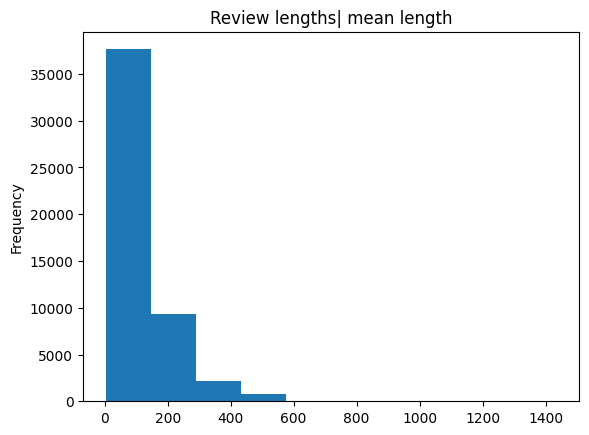

In [22]:
df['review_len'].plot(kind='hist')
plt.title('Review lengths| mean length')

### Padding / Truncating the remaining data

To deal with both short and long reviews, we will pad or truncate all our reviews to a specific length. We define this length by Sequence Length. This sequence length is same as number of time steps for LSTM layer.

For reviews shorter than seq_length, we will pad with 0s. For reviews longer than seq_length we will truncate them to the first seq_length words.

In [23]:
df.head()

,review,sentiment,review_int,review_len
0,one reviewer mentioned watching a of episode hooked right exactly happened first thing struck of brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word called of nickname given oswald maximum security state penitentiary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda pm city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show dare forget pretty picture painted mainstream audience forget charm forget romance of mess around first episode ever saw struck nasty surreal say ready watched developed taste of got accustomed high level graphic violence violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison experience watching of may become comfortable uncomfortable viewing that get touch darker side,1,"[3, 1047, 925, 66, 4, 6, 170, 2976, 101, 506, 485, 24, 27, 3005, 6, 4972, 13092, 18, 453, 113, 101, 247, 32, 1533, 25, 6208, 2147, 10396, 25, 911, 1978, 1999, 576, 194, 453, 3448, 220, 257, 247, 326, 6, 9288, 251, 11106, 5909, 2356, 574, 20118, 746, 1258, 17938, 379, 4304, 1947, 1008, 1881, 1799, 789, 226, 37132, 14561, 199, 4057, 995, 379, 237, 39, 10944, 3784, 10795, 6209, 1131, 834, 2098, 18939, 201, 3909, 6658, 1608, 6908, 7583, 43, 129, 143, 13, 42, 179, 1059, 25, 538, 91, 32, 25, 2493, 690, 92, 243, 3851, 2331, 155, ...]",163
1,wonderful little production filming technique unassuming old time bic fashion give comforting sometimes discomforting sense realism entire piece actor extremely well chosen michael sheen got polar voice pat truly see seamless editing guided reference williams diary entry well worth watching terrific written performed piece masterful production one great master comedy life realism really come home little thing fantasy guard rather use traditional dream technique remains solid disappears play knowledge sens particularly scene concerning norton halliwell set particularly flat halliwell mural decorating every surface terribly well done,1,"[288, 48, 229, 1224, 1584, 15536, 70, 7, 2099, 1288, 63, 11922, 420, 19522, 183, 1668, 337, 233, 37, 448, 17, 2052, 366, 3836, 94, 6554, 357, 2929, 265, 15, 11580, 657, 8907, 1114, 1558, 5443, 2114, 17, 180, 66, 1183, 303, 2222, 233, 3997, 229, 3, 22, 798, 88, 29, 1668, 16, 54, 237, 48, 27, 771, 1874, 154, 257, 2011, 504, 1584, 1156, 1028, 4470, 69, 1658, 4203, 465, 18, 3416, 5490, 20817, 113, 465, 894, 20817, 17939, 22363, 79, 1640, 1803, 17, 119]",86
2,thought wonderful way spend time hot summer weekend sitting air conditioned theatre watching light hearted comedy plot simplistic dialogue witty character likable even well bread suspected serial killer may disappointed realize match point a risk addiction thought proof woody allen still fully control style many a grown love laughed one woody comedy year dare say decade never impressed scarlet johnson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wear prada interesting superman great comedy go see friend,1,"[89, 288, 26, 1009, 7, 702, 1243, 2324, 1091, 719, 12872, 343, 66, 427, 2147, 88, 36, 3785, 274, 1726, 9, 1327, 11, 17, 5618, 6169, 1260, 291, 106, 547, 816, 721, 83, 4, 2060, 4409, 89, 2699, 2571, 1552, 55, 1214, 909, 273, 39, 4, 1885, 35, 1289, 3, 2571, 88, 41, 2493, 42, 1165, 43, 1354, 2751, 1939, 1189, 938, 1100, 567, 4707, 101, 698, 3297, 100, 68, 106, 4382, 3804, 436, 24347, 1567, 1394, 17458, 122, 2285, 22, 88, 32, 15, 108]",85
3,basically family little boy jake think zombie closet parent fighting time movie slower soap opera suddenly jake decides become rambo kill zombie of first going make film must decide thriller drama drama movie watchable parent div

In [24]:
df['review_int'].shape

(50000,)

In [25]:
def Padding(review_int, seq_len):
    '''
    Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(review_int), seq_len), dtype = int)
    for i, review in enumerate(review_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)
            
    return features
features = Padding(df['review_int'], 200)
print(features.shape) #samples size, sequence len


(50000, 200)


### Splitting model into train-test/holdout split. Will further split train set into train and validation set later

In [26]:
from sklearn.model_selection import train_test_split
X=features
y=df['sentiment']
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.3, random_state=42,stratify=y)

#train_df=pd.concat([X_train,y_train],axis=1)
#X=train_df['review']
#y=train_df['sentiment']
#X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.3, random_state=42,stratify=y)

### Converting data into tensors 

In [27]:
from torch.utils.data import DataLoader, TensorDataset

X_train=torch.from_numpy(X_train).to(torch.float32)
y_train=torch.from_numpy(np.array(y_train)).to(torch.float32)
train_dataset=TensorDataset(X_train,y_train)
train_loader = DataLoader(train_dataset, batch_size=32)


#X_valid=torch.from_numpy(X_valid.toarray()).to(torch.float32)
#y_valid=torch.from_numpy(np.array(y_valid)).to(torch.float32)
#valid_dataset=TensorDataset(X_valid,y_valid)
#valid_loader = DataLoader(valid_dataset, batch_size=32)


X_holdout=torch.from_numpy(X_holdout).to(torch.float32)
y_holdout=torch.from_numpy(np.array(y_holdout)).to(torch.float32)
holdout_dataset=TensorDataset(X_holdout,y_holdout)
holdout_loader = DataLoader(holdout_dataset, batch_size=32)

In [28]:
train_dataset

In [29]:
data,label=next(iter(train_loader))
print(f'data shape: {data.shape}')
print(f'data dtype: {data.dtype}')
print(f'label shape: {label.shape}')
print(f'data dtype: {label.dtype}')

data.reshape(32,200,1).shape


data shape: torch.Size([32, 200])
data dtype: torch.float32
label shape: torch.Size([32])
data dtype: torch.float32


torch.Size([32, 200, 1])

In [30]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

### LSTM Model architecture

Tokenize : This is not a layer for LSTM network but a mandatory step of converting our words into tokens (integers)
Embedding Layer: that converts our word tokens (integers) into embedding of specific size
LSTM Layer: defined by hidden state dims and number of layers
Fully Connected Layer: that maps output of LSTM layer to a desired output size


    num_embeddings = How large is the vocabulary? How many categories are you encoding? This parameter is the number of items in your "lookup table."
    embedding_dim = How many numbers in the vector you wish to return.


In [31]:
class model(nn.Module):
    def __init__(self,vocab_size, output_dim, embedding_dim, hidden_dim, num_layers, dropout):
        super(model,self).__init__()
        self.vocab_size=vocab_size
        self.num_layers=num_layers
        self.hidden_dim=hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm=nn.LSTM(embedding_dim,hidden_dim,num_layers,batch_first=True,dropout=dropout)
        self.dropout=nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim, output_dim)
        

    def forward(self,x):
        h0=torch.zeros(self.num_layers,x.size(0),self.hidden_dim).to(device)
        c0=torch.zeros(self.num_layers,x.size(0),self.hidden_dim).to(device)
        
        x=self.embedding(x)
        out,_=self.lstm(x,(h0.detach(),c0.detach()))
        out = out[:, -1, :]
        x=self.dropout(out)
        x=self.fc1(out)
        

        return x
        
    

In [32]:
len(vocab_to_int)

57616

In [33]:
vocab_size=len(vocab_to_int)+1
embedding_dim=64
hidden_dim = 128
output_dim = 1  # Binary classification (positive/negative)
num_layers = 2
dropout=0.2
sequence_length=200
learning_rate=0.001
num_epochs=5
net=model(vocab_size,output_dim,embedding_dim,hidden_dim,num_layers,dropout).to(device)


### Train and test Loop with stratifiedKFold cross validation technique 

The initial input shape to the embedding layer should be (batch size, sequence length).
After embedding, the features are automatically added based on the embedding size.
Therefore, reshaping to (batch size, sequence length, 1) is not required for the embedding layer!

embedding:
(batch_size, sequence_length) → (batch_size, sequence_length, embedding_dim)


In [34]:
import torchmetrics
from torchmetrics.classification import BinaryAccuracy
from torch.nn import BCEWithLogitsLoss
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold




skf=StratifiedKFold(n_splits=3)
test_loss=[]
total_acc=[]
for fold, (train_idx, test_idx) in enumerate(skf.split(X_train,y_train)):
    print(f"Fold {fold + 1}")
    print("-------")

    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=32,
            sampler=torch.utils.data.SubsetRandomSampler(train_idx),
        )
    
    valid_loader = DataLoader(
            dataset=train_dataset,
            batch_size=32,
            sampler=torch.utils.data.SubsetRandomSampler(test_idx),
        )
    
    metric=BinaryAccuracy().to(device)
    bce=BCEWithLogitsLoss()
    optim = torch.optim.Adam(net.parameters(), lr=learning_rate) 
    
    for epoch in tqdm(range(num_epochs)):
        running_loss=0
        #train loop
        
        net.train()
        for batch_size,(X,y) in enumerate(train_loader):
            optim.zero_grad()
            
            X=X.long().to(device) 
            y=y.to(device)
            
            pred=net(X)
            loss=bce(pred.squeeze(),y)
            running_loss+=loss
            
            loss.backward()
            optim.step()
            
        avg_train_loss=running_loss/len(train_loader)
        
        #print('\nTraining Finished\n')
    
        #validation loop
        net.eval()
        with torch.inference_mode():
            for batch_size,(X,y) in enumerate(valid_loader):
                X=X.long().to(device) #X alr in shape()
                y=y.to(device)
                pred=net(X)
                running_loss+=bce(pred.squeeze(),y)
                metric(pred.squeeze(),y)
                
            avg_loss=running_loss/len(valid_loader)
            #total accuracy over all validation batches
            avg_acc=metric.compute()
            test_loss.append(avg_loss.item())
            total_acc.append(avg_acc.item())
            #print(f'Epoch: {epoch+1} | Train Loss : {avg_train_loss} | Valid Loss: {avg_loss} | Valid Accuracy: {avg_acc}')
            
            #Reset metric states after each epoch
            metric.reset()
            
        #print('\nValidation Finished\n')
    print(f'Average Validation loss:{np.mean(test_loss)} | Average Validation Accuracy score:{np.mean(total_acc)} ')
        
    

Fold 1
-------


  0%|          | 0/5 [00:00<?, ?it/s]

Average Validation loss:1.0835679054260254 | Average Validation Accuracy score:0.8287134647369385 
Fold 2
-------


  0%|          | 0/5 [00:00<?, ?it/s]

Average Validation loss:0.7659476459026336 | Average Validation Accuracy score:0.8844004452228547 
Fold 3
-------


  0%|          | 0/5 [00:00<?, ?it/s]

Average Validation loss:0.5640196522076925 | Average Validation Accuracy score:0.9174761772155762 


### Finding best hyperparameters of model using Optuna

In [35]:
import optuna

def define_model(trial):
    params={
    'vocab_size': len(vocab_to_int)+1,
    'output_dim':1,
    'embedding_dim': trial.suggest_int('embedding_dim',16,128),
    'hidden_dim' : trial.suggest_int('hidden_dim', 16, 128),
    'num_layers' : trial.suggest_int('num_layers', 2, 5),
    'dropout' : trial.suggest_float("dropout", 0.2, 0.5),
    'output_dim':1
    }
    

    return model(**params)


def objective(trial):
    # Generate the model.
    model = define_model(trial).to(device)
    
    #learning_rate = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    metric=BinaryAccuracy().to(device)
    bce=BCEWithLogitsLoss()
    optim = torch.optim.Adam(net.parameters(), lr=0.001) 
    
    skf=StratifiedKFold(n_splits=3)
    test_loss=[]
    total_acc=[]
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_train,y_train)):
        print(f"Fold {fold + 1}")
        #print("-------")
    
        train_loader = DataLoader(
                dataset=train_dataset,
                batch_size=32,
                sampler=torch.utils.data.SubsetRandomSampler(train_idx),
            )
        
        valid_loader = DataLoader(
                dataset=train_dataset,
                batch_size=32,
                sampler=torch.utils.data.SubsetRandomSampler(test_idx),
            )
        
        metric=BinaryAccuracy().to(device)
        bce=BCEWithLogitsLoss()
        optim = torch.optim.Adam(net.parameters(), lr=learning_rate) 
        
        for epoch in range(num_epochs):
            running_loss=0
            #train loop
            
            net.train()
            for batch_size,(X,y) in enumerate(train_loader):
                optim.zero_grad()
                
                X=X.long().to(device) 
                y=y.to(device)
                
                pred=net(X)
                loss=bce(pred.squeeze(),y)
                running_loss+=loss
                
                loss.backward()
                optim.step()
                
            avg_train_loss=running_loss/len(train_loader)
            
            #print('\nTraining Finished\n')
        
            #validation loop
            net.eval()
            with torch.inference_mode():
                for batch_size,(X,y) in enumerate(valid_loader):
                    X=X.long().to(device)
                    y=y.to(device)
                    pred=net(X)
                    running_loss+=bce(pred.squeeze(),y)
                    metric(pred.squeeze(),y)
                    
                avg_loss=running_loss/len(valid_loader)
                #total accuracy over all validation batches
                avg_acc=metric.compute()
                test_loss.append(avg_loss.item())
                total_acc.append(avg_acc.item())
                print(f'Epoch: {epoch+1} | Train Loss : {avg_train_loss} | Valid Loss: {avg_loss} | Valid Accuracy: {avg_acc}')
                
                #Reset metric states after each epoch
                metric.reset()
                
                acc=np.mean(total_acc)
                trial.report(acc, epoch)
                
                if trial.should_prune():
                    raise optuna.exceptions.TrialPruned()
                    
    return np.mean(total_acc)

        

### Taking note of best parameters

In [36]:
from optuna.trial import TrialState
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
        print(" {}: {}".format(key, value))

[I 2025-01-01 15:25:43,153] A new study created in memory with name: no-name-a853d602-6b09-4a33-bf3e-d014f879015a


Fold 1
Epoch: 1 | Train Loss : 0.03510117158293724 | Valid Loss: 0.0849086344242096 | Valid Accuracy: 0.9961429834365845
Epoch: 2 | Train Loss : 0.012990080751478672 | Valid Loss: 0.05457780510187149 | Valid Accuracy: 0.990657389163971
Epoch: 3 | Train Loss : 0.007227638736367226 | Valid Loss: 0.03168380632996559 | Valid Accuracy: 0.9947715997695923
Epoch: 4 | Train Loss : 0.00459893885999918 | Valid Loss: 0.042403873056173325 | Valid Accuracy: 0.990743100643158
Epoch: 5 | Train Loss : 0.0111722806468606 | Valid Loss: 0.07041626423597336 | Valid Accuracy: 0.9850004315376282
Fold 2
Epoch: 1 | Train Loss : 0.025130100548267365 | Valid Loss: 0.05582990497350693 | Valid Accuracy: 0.9989714622497559


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Epoch: 2 | Train Loss : 0.005551922135055065 | Valid Loss: 0.018270304426550865 | Valid Accuracy: 0.9975143671035767


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


Epoch: 3 | Train Loss : 0.00896965991705656 | Valid Loss: 0.048613473773002625 | Valid Accuracy: 0.9893717169761658


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


Epoch: 4 | Train Loss : 0.006202309858053923 | Valid Loss: 0.02667059563100338 | Valid Accuracy: 0.9950287342071533


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


Epoch: 5 | Train Loss : 0.0016253481153398752 | Valid Loss: 0.022417230531573296 | Valid Accuracy: 0.9938287734985352
Fold 3


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


Epoch: 1 | Train Loss : 0.013331640511751175 | Valid Loss: 0.027779124677181244 | Valid Accuracy: 0.999742865562439
Epoch: 2 | Train Loss : 0.004849704913794994 | Valid Loss: 0.011361207813024521 | Valid Accuracy: 0.9993142485618591
Epoch: 3 | Train Loss : 0.0015538431471213698 | Valid Loss: 0.005074547603726387 | Valid Accuracy: 0.9993999600410461
Epoch: 4 | Train Loss : 0.0005373927997425199 | Valid Loss: 0.002895308192819357 | Valid Accuracy: 0.9994856715202332


[I 2025-01-01 15:27:20,128] Trial 0 finished with value: 0.9952972650527954 and parameters: {'embedding_dim': 25, 'hidden_dim': 74, 'num_layers': 2, 'dropout': 0.3909258548016622}. Best is trial 0 with value: 0.9952972650527954.


Epoch: 5 | Train Loss : 9.885500912787393e-05 | Valid Loss: 0.0016316140536218882 | Valid Accuracy: 0.9994856715202332
Fold 1
Epoch: 1 | Train Loss : 0.005293761845678091 | Valid Loss: 0.040521007031202316 | Valid Accuracy: 0.9900574088096619
Epoch: 2 | Train Loss : 0.002618046710267663 | Valid Loss: 0.008343853987753391 | Valid Accuracy: 0.9991428852081299
Epoch: 3 | Train Loss : 0.00026120321126654744 | Valid Loss: 0.001998989610001445 | Valid Accuracy: 0.999657154083252
Epoch: 4 | Train Loss : 2.1904636014369316e-05 | Valid Loss: 0.001697517349384725 | Valid Accuracy: 0.9994857311248779
Epoch: 5 | Train Loss : 1.3931415196566377e-05 | Valid Loss: 0.0017798617482185364 | Valid Accuracy: 0.9994857311248779
Fold 2
Epoch: 1 | Train Loss : 0.004281304311007261 | Valid Loss: 0.009364410303533077 | Valid Accuracy: 0.999742865562439


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Epoch: 2 | Train Loss : 0.001560470089316368 | Valid Loss: 0.005032356828451157 | Valid Accuracy: 0.9994000196456909


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


Epoch: 3 | Train Loss : 0.0011481276014819741 | Valid Loss: 0.0037456040736287832 | Valid Accuracy: 0.9994857311248779


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


Epoch: 4 | Train Loss : 0.00025848919176496565 | Valid Loss: 0.0038207476027309895 | Valid Accuracy: 0.9988857507705688


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


Epoch: 5 | Train Loss : 0.0043492927215993404 | Valid Loss: 0.03427319601178169 | Valid Accuracy: 0.9920287728309631
Fold 3


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


Epoch: 1 | Train Loss : 0.007163460366427898 | Valid Loss: 0.015582914464175701 | Valid Accuracy: 0.999742865562439
Epoch: 2 | Train Loss : 0.000856330618262291 | Valid Loss: 0.004023976624011993 | Valid Accuracy: 0.9991428256034851
Epoch: 3 | Train Loss : 0.0002486817538738251 | Valid Loss: 0.0026814453303813934 | Valid Accuracy: 0.9994856715202332
Epoch: 4 | Train Loss : 6.332014163490385e-05 | Valid Loss: 0.00293629989027977 | Valid Accuracy: 0.9993142485618591


[I 2025-01-01 15:28:57,702] Trial 1 finished with value: 0.9982971747716268 and parameters: {'embedding_dim': 18, 'hidden_dim': 121, 'num_layers': 2, 'dropout': 0.423786670645414}. Best is trial 1 with value: 0.9982971747716268.


Epoch: 5 | Train Loss : 1.0340330845792778e-05 | Valid Loss: 0.0027630848344415426 | Valid Accuracy: 0.9993999600410461
Fold 1
Epoch: 1 | Train Loss : 0.0029842073563486338 | Valid Loss: 0.006012916099280119 | Valid Accuracy: 1.0
Epoch: 2 | Train Loss : 0.0001589552848599851 | Valid Loss: 0.000681914621964097 | Valid Accuracy: 0.999828577041626
Epoch: 3 | Train Loss : 1.257121311937226e-05 | Valid Loss: 0.00016876882000360638 | Valid Accuracy: 0.999914288520813
Epoch: 4 | Train Loss : 8.876181709638331e-06 | Valid Loss: 0.0003161029308103025 | Valid Accuracy: 0.999914288520813
Epoch: 5 | Train Loss : 3.240190380893182e-06 | Valid Loss: 0.0003487914218567312 | Valid Accuracy: 0.999828577041626
Fold 2
Epoch: 1 | Train Loss : 0.0012049719225615263 | Valid Loss: 0.002888327231630683 | Valid Accuracy: 0.999828577041626


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Epoch: 2 | Train Loss : 0.002662152284756303 | Valid Loss: 0.007699199952185154 | Valid Accuracy: 0.9994000196456909


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


Epoch: 3 | Train Loss : 0.0024537849240005016 | Valid Loss: 0.006997878663241863 | Valid Accuracy: 0.9994857311248779


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


Epoch: 4 | Train Loss : 0.0001523728424217552 | Valid Loss: 0.0022167586721479893 | Valid Accuracy: 0.9994000196456909


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


Epoch: 5 | Train Loss : 2.2263617211137898e-05 | Valid Loss: 0.002005452523007989 | Valid Accuracy: 0.9994000196456909
Fold 3


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


Epoch: 1 | Train Loss : 0.004364197142422199 | Valid Loss: 0.008766396902501583 | Valid Accuracy: 1.0
Epoch: 2 | Train Loss : 0.0004097246564924717 | Valid Loss: 0.0009042574092745781 | Valid Accuracy: 1.0
Epoch: 3 | Train Loss : 3.783968713833019e-05 | Valid Loss: 0.00013997421774547547 | Valid Accuracy: 1.0
Epoch: 4 | Train Loss : 1.3541280168283265e-05 | Valid Loss: 8.713689021533355e-05 | Valid Accuracy: 1.0


[I 2025-01-01 15:30:35,000] Trial 2 finished with value: 0.9998000065485636 and parameters: {'embedding_dim': 87, 'hidden_dim': 62, 'num_layers': 5, 'dropout': 0.2065214500412857}. Best is trial 2 with value: 0.9998000065485636.


Epoch: 5 | Train Loss : 6.595222657779232e-06 | Valid Loss: 6.823923467891291e-05 | Valid Accuracy: 1.0
Fold 1
Epoch: 1 | Train Loss : 0.00349512230604887 | Valid Loss: 0.007040307391434908 | Valid Accuracy: 1.0
Epoch: 2 | Train Loss : 0.0004099382204003632 | Valid Loss: 0.001066825701855123 | Valid Accuracy: 0.999914288520813
Epoch: 3 | Train Loss : 1.702750705590006e-05 | Valid Loss: 0.00024661299539729953 | Valid Accuracy: 0.999914288520813
Epoch: 4 | Train Loss : 8.402686944464222e-06 | Valid Loss: 0.00020346759993117303 | Valid Accuracy: 0.999914288520813
Epoch: 5 | Train Loss : 3.2041880331235006e-06 | Valid Loss: 0.00021625611407216638 | Valid Accuracy: 0.999914288520813
Fold 2
Epoch: 1 | Train Loss : 0.0030532008968293667 | Valid Loss: 0.006907125469297171 | Valid Accuracy: 0.9994000196456909


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Epoch: 2 | Train Loss : 0.002057550707831979 | Valid Loss: 0.00514729181304574 | Valid Accuracy: 0.999742865562439


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


Epoch: 3 | Train Loss : 0.0004259264678694308 | Valid Loss: 0.0018723256653174758 | Valid Accuracy: 0.9994857311248779


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


Epoch: 4 | Train Loss : 2.3564722141600214e-05 | Valid Loss: 0.0008156287367455661 | Valid Accuracy: 0.9995714426040649


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


Epoch: 5 | Train Loss : 6.467472303484101e-06 | Valid Loss: 0.0009066952625289559 | Valid Accuracy: 0.9994000196456909
Fold 3


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


Epoch: 1 | Train Loss : 0.003396890126168728 | Valid Loss: 0.007073633838444948 | Valid Accuracy: 0.999914288520813
Epoch: 2 | Train Loss : 0.0013751628575846553 | Valid Loss: 0.003151015844196081 | Valid Accuracy: 0.999914288520813
Epoch: 3 | Train Loss : 0.00035720618325285614 | Valid Loss: 0.0018478541169315577 | Valid Accuracy: 0.9995713829994202
Epoch: 4 | Train Loss : 1.4602547707909252e-05 | Valid Loss: 0.000688192609231919 | Valid Accuracy: 0.999742865562439


[I 2025-01-01 15:32:11,744] Trial 3 finished with value: 0.9997485756874085 and parameters: {'embedding_dim': 53, 'hidden_dim': 113, 'num_layers': 3, 'dropout': 0.3698072708737462}. Best is trial 2 with value: 0.9998000065485636.


Epoch: 5 | Train Loss : 5.86659098189557e-06 | Valid Loss: 0.0007304069586098194 | Valid Accuracy: 0.999828577041626
Fold 1
Epoch: 1 | Train Loss : 0.0008121308637782931 | Valid Loss: 0.00200782367028296 | Valid Accuracy: 0.999914288520813
Epoch: 2 | Train Loss : 0.0026201824657619 | Valid Loss: 0.009962018579244614 | Valid Accuracy: 0.9986286163330078
Epoch: 3 | Train Loss : 0.0009628211264498532 | Valid Loss: 0.0037431002128869295 | Valid Accuracy: 0.9995714426040649
Epoch: 4 | Train Loss : 0.00044161983532831073 | Valid Loss: 0.002552850404754281 | Valid Accuracy: 0.9995714426040649
Epoch: 5 | Train Loss : 1.8186718079959974e-05 | Valid Loss: 0.0018525492632761598 | Valid Accuracy: 0.9994857311248779
Fold 2
Epoch: 1 | Train Loss : 0.002534874016419053 | Valid Loss: 0.005261636804789305 | Valid Accuracy: 0.999914288520813


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Epoch: 2 | Train Loss : 5.237237928668037e-05 | Valid Loss: 0.00028585983091033995 | Valid Accuracy: 0.999914288520813


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


Epoch: 3 | Train Loss : 2.265163857373409e-05 | Valid Loss: 0.0001542444369988516 | Valid Accuracy: 1.0


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


Epoch: 4 | Train Loss : 8.042663466767408e-06 | Valid Loss: 8.086764137260616e-05 | Valid Accuracy: 1.0


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


Epoch: 5 | Train Loss : 2.9306986562005477e-06 | Valid Loss: 7.017870666459203e-05 | Valid Accuracy: 1.0
Fold 3


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


Epoch: 1 | Train Loss : 0.0006575968582183123 | Valid Loss: 0.0013175532221794128 | Valid Accuracy: 1.0
Epoch: 2 | Train Loss : 0.004051591269671917 | Valid Loss: 0.010584729723632336 | Valid Accuracy: 0.9991428256034851
Epoch: 3 | Train Loss : 0.0011886408319696784 | Valid Loss: 0.003974787890911102 | Valid Accuracy: 0.9995713829994202
Epoch: 4 | Train Loss : 2.8945116355316713e-05 | Valid Loss: 0.0019106341060250998 | Valid Accuracy: 0.9995713829994202


[I 2025-01-01 15:33:48,463] Trial 4 finished with value: 0.99965713818868 and parameters: {'embedding_dim': 63, 'hidden_dim': 109, 'num_layers': 5, 'dropout': 0.20280365212335397}. Best is trial 2 with value: 0.9998000065485636.


Epoch: 5 | Train Loss : 1.2930823686474469e-05 | Valid Loss: 0.0018602407071739435 | Valid Accuracy: 0.9995713829994202
Study statistics: 
  Number of finished trials:  5
  Number of pruned trials:  0
  Number of complete trials:  5
Best trial:
  Value:  0.9998000065485636
  Params: 
 embedding_dim: 87
 hidden_dim: 62
 num_layers: 5
 dropout: 0.2065214500412857


### Best Params + Learning Rate, retrain model using this now

In [37]:
best_params={'embedding_dim':118,
             'hidden_dim':59,
             'num_layers':5,
             'dropout':0.24709261401921034,
             'vocab_size': len(vocab_to_int)+1,
             'output_dim':1}
best_lr=0.001






In [38]:
net=model(**best_params)
net

model(
  (embedding): Embedding(57617, 118)
  (lstm): LSTM(118, 59, num_layers=5, batch_first=True, dropout=0.24709261401921034)
  (dropout): Dropout(p=0.24709261401921034, inplace=False)
  (fc1): Linear(in_features=59, out_features=1, bias=True)
)

In [39]:
import torchmetrics
from torchmetrics.classification import BinaryAccuracy
from torch.nn import BCEWithLogitsLoss
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold

net=model(**best_params).to(device)

test_loss=[]
total_acc=[]


train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=32,
        )
    

    
metric=BinaryAccuracy().to(device)
bce=BCEWithLogitsLoss()
optim = torch.optim.Adam(net.parameters(), lr=best_lr) 
    
for epoch in tqdm(range(5)):
        running_loss=0
        #train loop
        
        net.train()
        for batch_size,(X,y) in enumerate(train_loader):
            optim.zero_grad()
            
            X=X.long().to(device) 
            y=y.to(device)
            
            pred=net(X)
            loss=bce(pred.squeeze(),y)
            running_loss+=loss
            
            loss.backward()
            optim.step()
            
        
        
print('\nTraining Finished\n')
    
        
        

  0%|          | 0/5 [00:00<?, ?it/s]


Training Finished



### Testing on holdout set

https://www.youtube.com/watch?v=4i4C3ejTdgs

In [40]:
from torchmetrics.classification import BinaryAccuracy
from torchmetrics.classification import BinaryAUROC
auroc = BinaryAUROC().to(device)
metric=BinaryAccuracy().to(device)
for b,(X,y) in enumerate(holdout_loader):
    X=X.long().to(device)
    y=y.to(device)
    #print(X.shape)
    
    pred=net(X)
    #print(pred.shape)
    acc=metric(pred.squeeze(),y)
    auroc.update(pred.squeeze(), y)
final_acc=metric.compute()
final_auroc=auroc.compute()
print('TEST SET')
print(f'final_acc: {final_acc.item()}')
print(f'final_auroc: {final_auroc.item()}')
    

TEST SET
final_acc: 0.8712666630744934
final_auroc: 0.9435921907424927


In [41]:
def full_processing(text):
    text=cleaningtext(text)
    text=removing_stopwords(text)
    text=correct_spelling_symspell(text)
    text=[[vocab_to_int[word] for word in text.split()]]
    res=Padding(text,200)
    return torch.from_numpy(res).to(device)

def final_pred(model,text):
    text=full_processing(text)
    model.eval()
    with torch.inference_mode():
        pred=net(text)
        pred_prob=torch.sigmoid(pred).item()
        print(f'Proability: {pred_prob}')
        if pred_prob>0.5:
            print(f'text | Sentimental Analysis: POSITIVE')
        else:
            print(f'text | Sentimental Analysis: NEGATIVE')

### Examples

In [42]:
good="The Pursuit of Happyness is a powerful and uplifting film that masterfully portrays the human spirit’s ability to endure against insurmountable odds. Directed by Gabriele Muccino and starring Will Smith in an award-winning performance, this inspirational biographical drama captures the heart and soul of a father's love for his son and his unwavering determination to overcome life's hardships"

bad='i fking hate this movie it is so shit and bad fk this'

In [43]:
final_pred(net,bad)

Proability: 0.2064765989780426
text | Sentimental Analysis: NEGATIVE


In [44]:
final_pred(net,good)

Proability: 0.9877970814704895
text | Sentimental Analysis: POSITIVE
